# NN base : base neural network
- **target**: spco2
- **features**: [sst, sss, chl, mld, xco2, T0, T1, A, B, C]


In [82]:
import os
import numpy as np
import pandas as pd
import xarray as xr
#import seaborn as sns
import matplotlib.pyplot as plt

# modeling
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 100)

## Define useful functions

In [65]:
def repeat_lat_and_lon(ds=None):
    lon = np.arange(0.5,360,1)
    lat = np.arange(-89.5,90,1)
    ds_bc = xr.DataArray(np.zeros([len(lon),len(lat)]), coords=[('lon', lon),('lat', lat)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_lon(ds=None):
    lon = np.arange(0.5,360,1)
    ds_bc = xr.DataArray(np.zeros([len(lon)]), coords=[('lon', lon)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_lat(ds=None):
    lat = np.arange(-89.5,90,1)
    ds_bc = xr.DataArray(np.zeros([len(lat)]), coords=[('lat', lat)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_time(ds=None, dates=None):
    ''' dates needs to be a pandas date_range
    Example
    dates = pd.date_range(start='1982-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
    '''
    ds_bc = xr.DataArray(np.zeros([len(dates)]), coords=[('time', dates)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

def repeat_time_and_lon(ds=None, dates=None):
    ''' dates needs to be a pandas date_range
    Example
    dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
    '''
    lon = np.arange(0.5,360,1)
    ds_bc = xr.DataArray(np.zeros([len(dates), len(lon), ]), coords=[('time', dates),('lon', lon)])
    ds_data, ds_mask = xr.broadcast(ds, ds_bc)
    return ds_data

In [6]:
import numpy as np

# Define functions
def transform_doy(obj, dim='time'):
    '''
    transform_doy(ds, dim='time')
    transform DOY into repeating cycles
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    obj['T0'] = np.cos(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    obj['T1'] = np.sin(obj[f'{dim}.dayofyear'] * 2 * np.pi / 365)
    return obj[['T0','T1']]

def compute_n_vector(obj, dim_lon='lon', dim_lat='lat'):
    '''
    compute_n_vector(ds,dim_lon='lon', dim_lat='lat')
    calculate n-vector from lat/lon
    
    reference
    ==========
    Gregor et al. 2019 
    '''
    ### convert lat/lon to radians
    obj['lat_rad'], obj['lon_rad'] = np.radians(obj[dim_lat]), np.radians(obj[dim_lon])

    ### Calculate n-vector
    obj['A'], obj['B'], obj['C'] = np.sin(obj['lat_rad']), \
                            np.sin(obj['lon_rad'])*np.cos(obj['lat_rad']), \
                            -np.cos(obj['lon_rad'])*np.cos(obj['lat_rad'])
    return obj[['A','B','C']]

In [3]:
import xarray as xr
from skimage.filters import sobel

def network_mask():
    '''network_mask
    This masks out regions in the 
    NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html)
    to define the open ocean. Regions removed include:
    - Coast : defined by sobel filter
    - Batymetry less than 100m
    - Arctic ocean : defined as North of 79N
    - Hudson Bay
    - caspian sea, black sea, mediterranean sea, baltic sea, Java sea, Red sea
    '''
    ### Load obs directory
    dir_obs = '/local/data/artemis/observations'
    
    ### topography
    ds_topo = xr.open_dataset(f'{dir_obs}/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc')
    ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
    ds_topo['lon'] = np.arange(0.5, 360, 1)

    ### Loads grids
    # land-sea mask
    # land=0, sea=1
    ds_lsmask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')
    data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
    ### Define Latitude and Longitude
    lon = ds_lsmask['lon']
    lat = ds_lsmask['lat']
    
    ### Remove coastal points, defined by sobel edge detection
    coast = (sobel(ds_lsmask['mask'])>0)
    data = data.where(coast==0)
    
    ### Remove shallow sea, less than 100m
    ### This picks out the Solomon islands and Somoa
    data = data.where(ds_topo['Height']<-100)
    
    ### remove arctic
    data = data.where(~((lat>79)))
    data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
    data = data.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

    ### remove caspian sea, black sea, mediterranean sea, and baltic sea
    data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))
    
    ### remove hudson bay
    data = data.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
    data = data.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))
    
    ### Remove Red sea
    data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
    data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))
    
    return data

## Load data

In [4]:
# Data directory
# This is pre-processed data
dir_data='/local/data/artemis/observations/neural_net_data'

# Observations dictionary
dict_data = {'spco2': f'{dir_data}/spco2_1x1_mon_SOCATv2019_199801-201712.nc', 
             'sst': f'{dir_data}/sst_1x1_mon_NOAAOIv2_199801-201712.nc',
             'sss': f'{dir_data}/sss_1x1_mon_EN421_199801-201712.nc',
             'chl': f'{dir_data}/chl_1x1_mon_globColour_199801-201712.nc',
             'mld': f'{dir_data}/mld_1x1_clim_deBoyer_199801-201712.nc',
             'xco2': f'{dir_data}/xco2_1x1_mon_globalview_199801-201712.nc'}

###  Load all variables into common dataset
ds = xr.merge([xr.open_dataset(dict_data['sst']),
               xr.open_dataset(dict_data['sss']),
               xr.open_dataset(dict_data['chl']),
               xr.open_dataset(dict_data['mld']),
               xr.open_dataset(dict_data['xco2']),
               xr.open_dataset(dict_data['spco2'])])

In [61]:
# Create a date vector
dates = pd.date_range(start='1998-01-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')

ds  = xr.merge([ds, ## Standard variables
                #detrend(ds['SST'], dim='time').rename('SST_detrend'),
                repeat_lat_and_lon( transform_doy(ds) ),           
                repeat_time_and_lon( compute_n_vector(ds)['A'] , dates=dates),
                repeat_time( compute_n_vector(ds)[['B','C']], dates=dates)])       

In [63]:
ds = ds.transpose('time','lat','lon').drop(['lat_rad','lon_rad'])

In [64]:
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 432)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... -1.79 -1.79 -1.79
    sss      (time, lat, lon) float32 nan nan nan ... 31.211632 31.22952
    chl      (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    mld      (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    xco2     (time, lat, lon) float64 nan nan nan nan ... 406.4 406.4 406.4
    spco2    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    T0       (time, lat, lon) float64 0.9668 0.9668 0.9668 ... 0.9623 0.9623
    T1       (time, lat, lon) float64 0.2554 0.2554 0.2554 ... -0.272 -0.272
    A        (time, lat, lon) float32 -0.9999619 -0.9999619 ..

## Mask data

In [66]:
# Define my network mask
mask = network_mask()

In [70]:
# Apply mask to dataset
ds = ds.where(mask==1)

## Put into dataframe

In [73]:
### Put data into dataframe 
df = ds.to_dataframe().reset_index()

### select variables and drop nans 
df.dropna(subset=['lon', 'lat', 'time',
                  'A', 'B', 'C',
                  'T0', 'T1',
                  'sst', 'sss', 
                  'chl', 'mld', 
                  'xco2', 'spco2'], inplace=True)

In [74]:
df.head()

,lat,lon,time,sst,sss,chl,mld,xco2,spco2,T0,T1,A,B,C
2092860,-76.5,164.5,2003-01-15,-0.94,34.160316,0.314534,18.729113,374.796520,278.475037,0.966848,0.255353,-0.97237,0.062386,0.224955
2092872,-76.5,164.5,2004-01-15,-0.82,34.143547,0.356009,18.729113,376.998760,213.402817,0.966848,0.255353,-0.97237,0.062386,0.224955
2092873,-76.5,164.5,2004-02-15,-0.88,33.959709,0.763949,23.885191,377.540533,199.720215,0.702527,0.711657,-0.97237,0.062386,0.224955
2092909,-76.5,164.5,2007-02-15,-0.37,33.936447,0.395035,23.885191,383.332733,190.667770,0.702527,0.711657,-0.97237,0.062386,0.224955
2092920,-76.5,164.5,2008-01-15,-0.87,33.994492,0.665366,18.729113,384.997100,201.477844,0.966848,0.255353,-0.97237,0.062386,0.224955


## Train / validation / test split

In [75]:
# Input features
features = ['sst', 'sss', 'chl', 'mld', 'xco2', 'A', 'B', 'C', 'T0', 'T1']

# Features with time, lat, lon included
features_plus_coords = features.copy()
features_plus_coords.extend(['time', 'lon', 'lat'])

In [78]:
# Input and Output
X = df.loc[:, features] 
y = df.loc[:,'spco2']

### Uses train_test_split build into sklearn.model_selection
### By default this method shuffles the data (30% = testing 70%=training/validation)
### Train  = 49%
### Valid  = 21%
### Test   = 30%
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state = 28)
del X_tmp
del y_tmp

### Select features for training
X_train_ready = X_train[features]
X_train_ready = X_train_ready.values
y_train_ready = y_train.values

### Select features for validation
X_val_ready = X_val[features]
X_val_ready = X_val_ready.values
y_val_ready = y_val.values

### Select features for testing
X_test_ready = X_test[features]
X_test_ready = X_test_ready.values
y_test_ready = y_test.values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(98641, 10) (98641,)
(42275, 10) (42275,)
(60393, 10) (60393,)


In [79]:
### make sure there are no nans anywhere
print('NaNs in X_train_ready:', np.isnan(X_train_ready).sum())
print('NaNs in y_train_ready:', np.isnan(y_train_ready).sum())

print('NaNs in X_val_ready:', np.isnan(X_val_ready).sum())
print('NaNs in y_val_ready:', np.isnan(y_val_ready).sum())

print('NaNs in X_test_ready:', np.isnan(X_test_ready).sum())
print('NaNs in y_test_ready:', np.isnan(y_test_ready).sum())

NaNs in X_train_ready: 0
NaNs in y_train_ready: 0
NaNs in X_val_ready: 0
NaNs in y_val_ready: 0
NaNs in X_test_ready: 0
NaNs in y_test_ready: 0


# Neural Network model

In [83]:
def FFN_Model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    return model

In [84]:
n_epochs = 60

model = FFN_Model()
history = model.fit(X_train_ready, y_train_ready, epochs=n_epochs, 
                    batch_size=1024, validation_data=(X_val_ready, y_val_ready))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 98641 samples, validate on 42275 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
98641/98641 [==============================] - 2s 18us/sample - loss: 50896.2343 - mean_squared_error: 50896.2344 - val_loss: 2770295.7614 - val_mean_squared_error: 2770295.7500
Epoch 2/60
98641/98641 [==============================] - 2s 16us/sample - loss: 1882.3921 - mean_squared_error: 1882.3921 - val_loss: 122312.7097 - val_mean_squared_error: 122312.7266
Epoch 3/60
98641/98641 [==============================] - 2s 16us/sample - loss: 1406.8053 - mean_squared_error: 1406.8052 - val_loss: 4909.6647 - val_mean_squared_error: 4909.6641
Epoch 4/60
98641/98641 [==============================] - 2s 16us/sample - loss: 1214.7760 - mean_squared_error:

## Plot training process

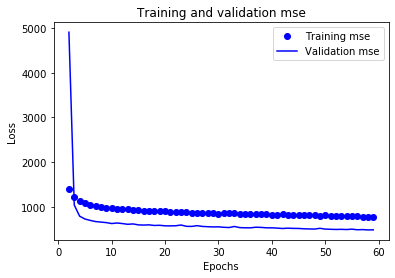

In [89]:
## training visualization
history_dict = history.history

epochs = range(n_epochs)
plt.clf() #Clears the figure 
acc_values = history_dict['mean_squared_error']
val_acc_values = history_dict['val_mean_squared_error']
plt.plot(epochs[2:], acc_values[2:], 'bo', label='Training mse')
plt.plot(epochs[2:], val_acc_values[2:], 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('training_w\cluster_full')

## Eveluation on test-set

In [90]:
pred_test = model.predict(X_test_ready)

In [120]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

RMSE = 21.258098898980315 uatm
r = [0.80597913]
R2 = [0.64960235]
p-value = [0.]


(150, 550)

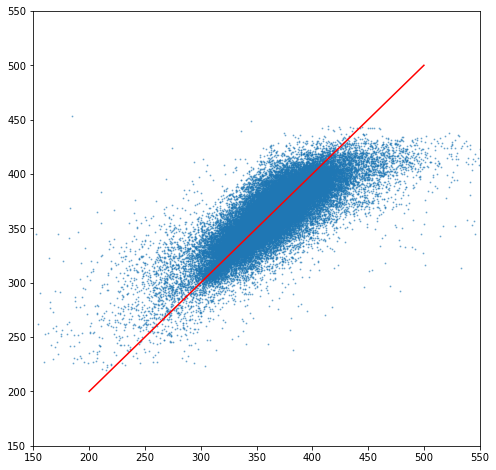

In [101]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_ready, pred_test, alpha = 0.5, s =0.8)
plt.plot([200, 500], [200,500], linestyle='-', color = 'red')
plt.xlim(150,550)
plt.ylim(150,550)
# plt.savefig(figdir+'base_ontest.png')

# Put predictions back to make a map

In [133]:
# Latitude, longitude vectors
lon = ds['lon']
lat = ds['lat']
time = ds['time']

# create a time,lat,lon skeleton
skeleton_xr = ds.to_dataframe().reset_index()
skeleton_xr = skeleton_xr[['time','lat','lon']]

# Make predictions - to final dataframe to be aware of coords
df_all = ds.to_dataframe().reset_index()
df_all = df_all[features_plus_coords].dropna()

In [135]:
df_all[features].head()

,sst,sss,chl,mld,xco2,A,B,C,T0,T1
2092800,-0.24,34.151615,0.953114,18.729113,365.070320,-0.97237,0.062386,0.224955,0.966848,0.255353
2092801,-0.11,34.064667,3.332136,23.885191,365.350433,-0.97237,0.062386,0.224955,0.702527,0.711657
2092802,-1.18,34.161743,0.000000,47.545898,365.753650,-0.97237,0.062386,0.224955,0.292600,0.956235
2092803,-1.72,34.188812,0.000000,168.681793,366.391750,-0.97237,0.062386,0.224955,-0.234491,0.972118
2092804,-1.65,34.182281,0.000000,0.000000,366.712675,-0.97237,0.062386,0.224955,-0.683919,0.729558


In [136]:
y_pred = model.predict(df_all[features])

In [137]:
# Put preidctionsinto dataframe
df_all['spco2_pred'] = y_pred

# merge the predictions into skeleton on the time, lat, lon coords
output = skeleton_xr.merge(df_all[['time', 'lat', 'lon', 'spco2_pred']], 
                           how = 'left', on = ['time','lat','lon'])

# Reshape output to (lat, lon, time)
dim_time, dim_lat, dim_lon = ds['spco2'].shape
out = output['spco2_pred'].values.reshape(dim_lat, dim_lon, dim_time)

# Put into xarray dataset
ds_out = xr.Dataset(
    {
    'spco2':(['lat', 'lon', 'time'], out),
    # 'error':(['lat', 'lon', 'time'], error),
    },

    coords={
    'time': (['time'], time),
    'lat': (['lat'], lat),
    'lon': (['lon'], lon),
    })

## Test plot

In [139]:
import cmocean as cm

/home/gloege/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


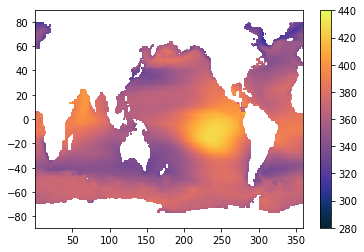

In [158]:
plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
plt.colorbar()

# Comparison at BATS

In [143]:
ds_bats = xr.open_dataset('/local/data/artemis/workspace/gloege/data/BATS/BATS.nc')

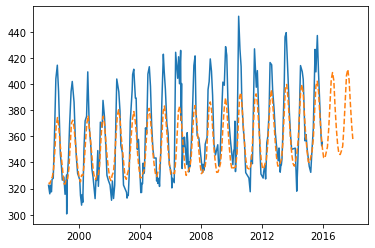

In [157]:
plt.plot(ds_bats['time'].sel(time=slice('1998-01-01','2017-12-31')), 
         ds_bats['spco2'].sel(time=slice('1998-01-01','2017-12-31')))
plt.plot(ds_out['time'], ds_out['spco2'].sel(lon=360-64, lat=32, method='nearest'),'--')

In [ ]:
rmse = mean_squared_error(y_test_ready, pred_test) ** 0.5
r, p = scipy.stats.pearsonr(np.expand_dims(y_test_ready, axis=1), pred_test)
print(f'RMSE = {rmse} uatm')
print(f'r = {r}')
print(f'R2 = {r**2}')
print(f'p-value = {p}')

# Comparison at HOT

In [151]:
ds_hot = xr.open_dataset('/local/data/artemis/workspace/gloege/data/HOT/HOT.nc')

In [154]:
ds_hot = ds_hot.where(ds_hot['spco2']>0)

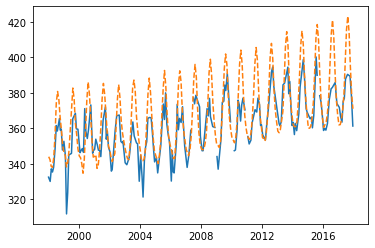

In [156]:
plt.plot(ds_hot['time'].sel(time=slice('1998-01-01','2017-12-31')), 
         ds_hot['spco2'].sel(time=slice('1998-01-01','2017-12-31')))
plt.plot(ds_out['time'], ds_out['spco2'].sel(lon=360-158, lat=22.75, method='nearest'),'--')